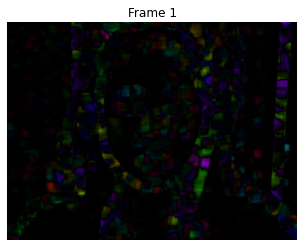

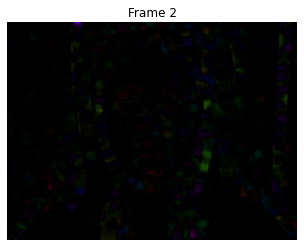

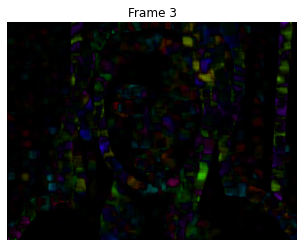

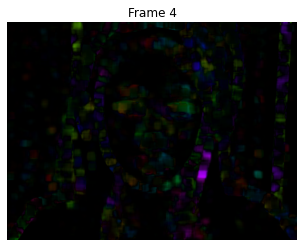

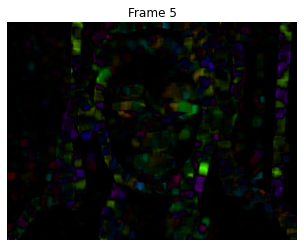

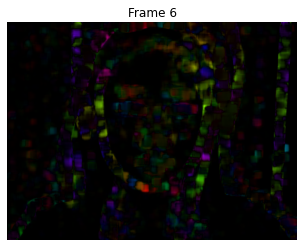

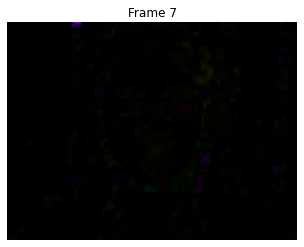

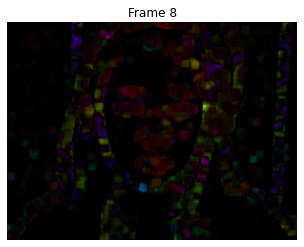

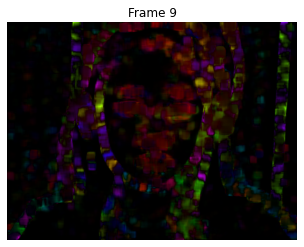

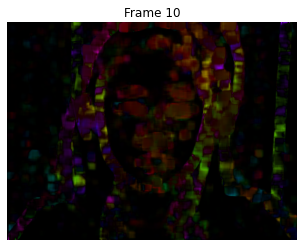

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import dlib
# Path to the directory containing the image frames
image_folder = "/persistent_data/MicroExpression-Datasets/data/happy1_1"
images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")])

# Function to display an image in Jupyter Notebook
def display_image(image, title=''):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Read the first frame
frame1 = cv2.imread(os.path.join(image_folder, images[0]))
# Convert to gray scale
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
# Create mask
hsv_mask = np.zeros_like(frame1)
# Make image saturation to a maximum value
hsv_mask[..., 1] = 255

# Iterate through the images
for i in range(1, len(images)):
    frame2 = cv2.imread(os.path.join(image_folder, images[i]))
    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Optical flow is now calculated
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # Compute magnitude and angle of 2D vector
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Set image hue value according to the angle of optical flow
    hsv_mask[..., 0] = ang * 180 / np.pi / 2
    # Set value as per the normalized magnitude of optical flow
    hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    # Convert to rgb
    rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)

    # Display the frame
    display_image(rgb_representation, f'Frame {i}')

    prvs = next


In [ ]:
def FarnebackOF(I1, I2, format='mat'):
    """
    calculate Farneback optical flow between frames *I1* and *I2*, return it in *format*

    Parameters
    ----------
    I1, I2 : 2-D numpy ndarray
             the frames I1 and I2 in grayscale
    format : string
             the format of the optical flow, can be 'mat' or 'rgb'
    
    Returns
    -------
    optical_flow : the calculated optical flow
    """
# Calculate optical flow using Farneback method
    flow = cv2.calcOpticalFlowFarneback(I1, I2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    if format == 'mat':
        return flow
    elif format == 'rgb':
        # Create an HSV mask
        hsv_mask = np.zeros((I1.shape[0], I1.shape[1], 3), dtype=np.uint8)
        hsv_mask[..., 1] = 255  # Saturation to maximum value

        # Compute magnitude and angle of 2D vector
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        # Set hue according to the optical flow direction
        hsv_mask[..., 0] = ang * 180 / np.pi / 2
        
        # Set value according to the normalized magnitude
        hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        
        # Convert HSV to BGR (which is RGB in OpenCV)
        rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)
        return rgb_representation
    else:
        raise ValueError("Invalid format. Use 'mat' or 'rgb'.")

def GetLandmarks(image):
    """
    get 68 face landmarks of the face in the given image

    Parameters
    ----------
    image : 
            a image containing face

    Returns
    -------
    landmarks : ndarray
                68 face landmarks [[x1, y1], [x2, y2], ..., [x68, y68]]
    """
# Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Load the pre-trained face detector from dlib
    detector = dlib.get_frontal_face_detector()
    
    # Load the pre-trained shape predictor (68 landmarks)
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    
    # Detect faces in the image
    faces = detector(gray)
    
    # Check if at least one face is detected
    if len(faces) == 0:
        return None
    
    # Assuming we're only interested in the first face detected
    face = faces[0]
    
    # Get the landmarks for the face
    landmarks = predictor(gray, face)
    
    # Convert landmarks to a numpy array
    landmarks_array = np.array([[p.x, p.y] for p in landmarks.parts()])
    
    return landmarks_array

def FaceCutBox(image, lmks):
    """
    calculate the face cutting box in image using 68 face landmarks based on 
    the method described in the Sec. 3.1 of "Research on Micro-Expression Spotting Method Based on Optical Flow Features"

    Parameters
    ----------
    image : 
            a image containing face
    lmks : ndarray
           the 68 face landmarks [[x1, y1], [x2, y2], ..., [x68, y68]]

    Returns
    -------
    cut_box : 
                 the face cutting box (top_left, lower_right)
    """
# Eye corners (assuming landmarks 36 and 45 are left and right eye corners)
    left_eye_corner = lmks[36]
    right_eye_corner = lmks[45]

    # Calculate the face cutting box coordinates
    xl = (left_eye_corner[0] + right_eye_corner[0]) / 2 - 4 * abs(left_eye_corner[0] - right_eye_corner[0]) / 2
    xr = (left_eye_corner[0] + right_eye_corner[0]) / 2 + 4 * abs(left_eye_corner[0] - right_eye_corner[0]) / 2
    yl = (left_eye_corner[1] + right_eye_corner[1]) / 2 - 3 * abs(left_eye_corner[1] - right_eye_corner[1]) / 2
    yr = (left_eye_corner[1] + right_eye_corner[1]) / 2 + 5 * abs(left_eye_corner[1] - right_eye_corner[1]) / 2

    # Top-left and lower-right corners of the cutting box
    top_left = (xl, yl)
    lower_right = (xr, yr)

    # Return the cutting box
    return top_left, lower_right

def FaceAlignment(images):
    """
    nose tip location-based image alignment described in Algorithm 1 of "Micro-expression spotting based on optical flow features"

    Parameters
    ----------
    images : list of images

    Returns
    -------
    cut_boxes : the aligned cut box in each image
    movement : the global movement
    """
    cut_boxes = []
    movements = []
    # Get landmarks for the first image (reference image)
    ref_lmks = GetLandmarks(images[0])
    ref_nose = ref_lmks[30]  # 31st point is the nose tip
    
    for img in images:
        lmks = GetLandmarks(img)
        if lmks is None:
            continue
        
        nose_tip = lmks[30]
        
        # Calculate movement vector from reference nose tip to current nose tip
        movement = ref_nose - nose_tip
        movements.append(movement)
        
        # Translate image based on movement
        rows, cols = img.shape[:2]
        M = np.float32([[1, 0, movement[0]], [0, 1, movement[1]]])
        aligned_img = cv2.warpAffine(img, M, (cols, rows))
        
        # Calculate the cut box for the aligned image
        cut_box = FaceCutBox(aligned_img, lmks)
        cut_boxes.append(cut_box)
    
    return cut_boxes, np.array(movements)

def MeanOF(flow, percent):
    """
    calcualte the mean optical flow with a large magnitude, i.e., eq(13) of "Micro-expression spotting based on optical flow features"

    Parameters
    ----------
    flow : the optical flow
    percent : how many percentage of the optical flow will be used for calculation

    Returns
    -------
    u : the mean optical flow
    """
  # Calculate the magnitude of the optical flow vectors
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Flatten the arrays to 1D for sorting
    mag_flat = mag.flatten()
    flow_flat = flow.reshape(-1, 2)

    # Determine the number of vectors to select
    num_vectors = int(len(mag_flat) * percent / 100)

    # Get the indices of the sorted magnitudes (in descending order)
    sorted_indices = np.argsort(-mag_flat)

    # Select the top percentage of flow vectors with the largest magnitudes
    top_indices = sorted_indices[:num_vectors]
    top_flow_vectors = flow_flat[top_indices]

    # Calculate the mean optical flow vector
    mean_flow = np.mean(top_flow_vectors, axis=0)

    return mean_flow